<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/00_%EC%8B%A4%EC%8A%B5%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from IPython import display

device ='cuda:0'
torch.__version__

'2.0.1+cu118'

## DataSet

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13138325.79it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


# **딥러닝심화 평가 과제** : CNN Model 최적화

**설문에도 답변 하셔야 합니다.**  

해당 코스 수료는   
1) 출석   
2) 평가   
3) 설문  

설문에도 반드시 답변하셔야 합니다.  

# 과제1 : 기준모델 성능 확인    
* 다음 기준 모델에 CIFAR-10 Dataset을 적용하여  
* 학습 후 최고 Accuracy를 확인하고,   
* Train, Validation Accuracy와 Loss를 Plotting 하자


## Model

In [ ]:
loss_function = nn.CrossEntropyLoss()

class CNN1(pl.LightningModule):
    def __init__(self):
        super(CNN1, self).__init__()
        self.layers = nn.Sequential(
            # conv 1
            nn.Conv2d(3, 64, 3, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),
            # conv 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # conv 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # classifier
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 10)
          )

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task='multiclass', num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task='multiclass', num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)
        if batch_idx==0 :
          print(f'Epoch{trainer.current_epoch} Val_loss:{loss:0.2f}, Val_acc:{acc:0.2f}')

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

cnn1 = CNN1()
summary(cnn1, input_size=(8, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Conv2d: 2-1                       [8, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         [8, 64, 32, 32]           --
│    └─MaxPool2d: 2-3                    [8, 64, 16, 16]           --
│    └─Conv2d: 2-4                       [8, 128, 16, 16]          73,856
│    └─ReLU: 2-5                         [8, 128, 16, 16]          --
│    └─MaxPool2d: 2-6                    [8, 128, 8, 8]            --
│    └─Conv2d: 2-7                       [8, 256, 8, 8]            295,168
│    └─ReLU: 2-8                         [8, 256, 8, 8]            --
│    └─MaxPool2d: 2-9                    [8, 256, 4, 4]            --
│    └─AdaptiveAvgPool2d: 2-10           [8, 256, 1, 1]            --
│    └─Flatten: 2-11                     [8, 256]                  --
│  

In [ ]:
%%time
cnn1 = CNN1()

_epochs = 15
name = "cnn1" ####
logger = CSVLogger("logs", name=name)
trainer = Trainer(max_epochs=_epochs, logger=logger, accelerator='auto',
                  limit_train_batches=0.3, limit_val_batches=0.5 )
trainer.fit(cnn1, trainloader, testloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 373 K 
--------------------------------------
373 K     Trainable params
0         Non-trainable params
373 K     Total params
1.494     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch0 Val_loss:2.30, Val_acc:0.09


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch0 Val_loss:1.78, Val_acc:0.30


Validation: 0it [00:00, ?it/s]

Epoch1 Val_loss:1.64, Val_acc:0.40


Validation: 0it [00:00, ?it/s]

Epoch2 Val_loss:1.51, Val_acc:0.46


Validation: 0it [00:00, ?it/s]

Epoch3 Val_loss:1.41, Val_acc:0.51


Validation: 0it [00:00, ?it/s]

Epoch4 Val_loss:1.35, Val_acc:0.52


Validation: 0it [00:00, ?it/s]

Epoch5 Val_loss:1.30, Val_acc:0.52


Validation: 0it [00:00, ?it/s]

Epoch6 Val_loss:1.25, Val_acc:0.54


Validation: 0it [00:00, ?it/s]

Epoch7 Val_loss:1.24, Val_acc:0.57


Validation: 0it [00:00, ?it/s]

Epoch8 Val_loss:1.20, Val_acc:0.56


Validation: 0it [00:00, ?it/s]

Epoch9 Val_loss:1.16, Val_acc:0.59


Validation: 0it [00:00, ?it/s]

Epoch10 Val_loss:1.16, Val_acc:0.61


Validation: 0it [00:00, ?it/s]

Epoch11 Val_loss:1.10, Val_acc:0.61


Validation: 0it [00:00, ?it/s]

Epoch12 Val_loss:1.08, Val_acc:0.60


Validation: 0it [00:00, ?it/s]

Epoch13 Val_loss:1.07, Val_acc:0.62


Validation: 0it [00:00, ?it/s]

Epoch14 Val_loss:1.07, Val_acc:0.62


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 1min 11s, sys: 542 ms, total: 1min 12s
Wall time: 1min 23s


In [ ]:
cnn1_num = logger.version

history1 = pd.read_csv(f'./logs/{name}/version_{cnn1_num}/metrics.csv')

history1_plot = history1.drop('step', axis=1).groupby('epoch').last()
history1_plot

,loss,acc,val_loss,val_acc
epoch,,,,
0,1.911575,0.226562,1.792205,0.347155
1,1.693936,0.382812,1.653374,0.374800
2,1.680445,0.367188,1.549181,0.434495
3,1.577507,0.414062,1.478198,0.459135
4,1.536992,0.445312,1.409272,0.492188
5,1.545089,0.484375,1.358453,0.511619
6,1.538171,0.421875,1.319259,0.522837
7,1.230353,0.539062,1.297248,0.530048
8,1.218777,0.554688,1.259591,0.547877


## ***Analysis***

Max Val_acc: 0.596754789352417


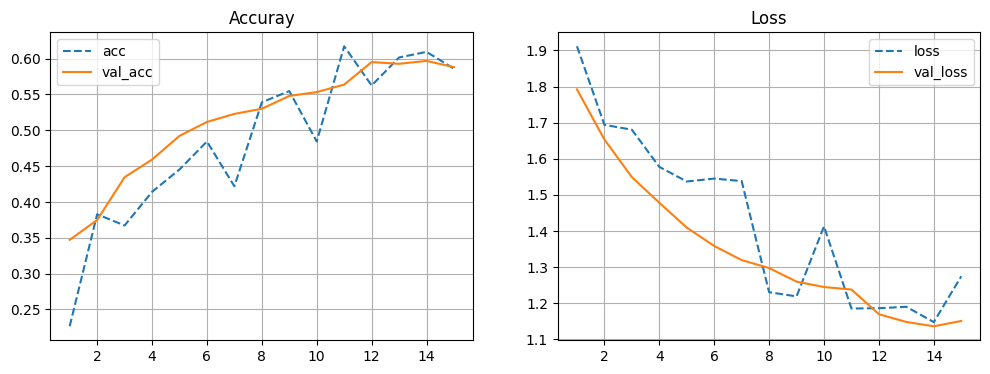

In [ ]:
print('Max Val_acc:',np.max(history1_plot['val_acc']))

xaxis = range(1, _epochs+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Accuray')
plt.plot(xaxis, history1_plot['acc'], '--', label='acc')
plt.plot(xaxis, history1_plot['val_acc'], '-', label='val_acc')
plt.grid(True)
#plt.ylim([0.95, 1.01])
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(xaxis, history1_plot['loss'], '--', label='loss')
plt.plot(xaxis, history1_plot['val_loss'], '-', label='val_loss')
plt.grid(True)
#plt.ylim([0.0, 0.6])
plt.legend()
plt.show()

# 과제2 : 성능 개선  (목표: > 75%)

**기준 모델을 수정하여 성능을 높여보자**  
주요 수정 사항  
1) Conv Layer의 수 및 각각의 node수 : 모델의 파라메터 수가 적절한가?    
2) BN Layer의 유무 : 학습이 너무 느린가?   
3) Dropout Layer의 유무 및 rate : 학습이 너무 빠른가?    
4) Learning rate 초기값 수정 : 학습속도가 적당한가?    
**기준모델과 성능을 비교하고 기록을 남기자**   


## 과제 2-1

### Model

In [ ]:
loss_function = nn.CrossEntropyLoss()

class CNN1(pl.LightningModule):
    def __init__(self):
        super(CNN1, self).__init__()
        self.layers = nn.Sequential(
            # conv 1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(2, 2),

            # conv 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(2, 2),

            # conv 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.MaxPool2d(2, 2),

            # classifier
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 10),
            nn.Dropout(0.2)
          )

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task='multiclass', num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task='multiclass', num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)
        if batch_idx==0 :
          print(f'Epoch{trainer.current_epoch} Val_loss:{loss:0.2f}, Val_acc:{acc:0.2f}')

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

cnn1 = CNN1()
summary(cnn1, input_size=(8, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Conv2d: 2-1                       [8, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [8, 64, 32, 32]           128
│    └─PReLU: 2-3                        [8, 64, 32, 32]           1
│    └─Conv2d: 2-4                       [8, 64, 32, 32]           36,928
│    └─BatchNorm2d: 2-5                  [8, 64, 32, 32]           128
│    └─PReLU: 2-6                        [8, 64, 32, 32]           1
│    └─MaxPool2d: 2-7                    [8, 64, 16, 16]           --
│    └─Conv2d: 2-8                       [8, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-9                  [8, 128, 16, 16]          256
│    └─PReLU: 2-10                       [8, 128, 16, 16]          1
│    └─Conv2d: 2-11                      [8, 128, 16, 16]          147,584

In [ ]:
%%time
cnn1 = CNN1()

_epochs = 15
name = "cnn1" ####
logger = CSVLogger("logs", name=name)
trainer = Trainer(max_epochs=_epochs, logger=logger, accelerator='auto',
                  limit_train_batches=0.3, limit_val_batches=0.5 )
trainer.fit(cnn1, trainloader, testloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.1 M 
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.599     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch0 Val_loss:2.30, Val_acc:0.09


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch0 Val_loss:1.46, Val_acc:0.46


Validation: 0it [00:00, ?it/s]

Epoch1 Val_loss:1.43, Val_acc:0.46


Validation: 0it [00:00, ?it/s]

Epoch2 Val_loss:1.32, Val_acc:0.54


Validation: 0it [00:00, ?it/s]

Epoch3 Val_loss:0.91, Val_acc:0.69


Validation: 0it [00:00, ?it/s]

Epoch4 Val_loss:0.96, Val_acc:0.65


Validation: 0it [00:00, ?it/s]

Epoch5 Val_loss:0.82, Val_acc:0.69


Validation: 0it [00:00, ?it/s]

Epoch6 Val_loss:1.23, Val_acc:0.60


Validation: 0it [00:00, ?it/s]

Epoch7 Val_loss:0.92, Val_acc:0.68


Validation: 0it [00:00, ?it/s]

Epoch8 Val_loss:0.86, Val_acc:0.72


Validation: 0it [00:00, ?it/s]

Epoch9 Val_loss:0.81, Val_acc:0.70


Validation: 0it [00:00, ?it/s]

Epoch10 Val_loss:0.80, Val_acc:0.73


Validation: 0it [00:00, ?it/s]

Epoch11 Val_loss:0.96, Val_acc:0.65


Validation: 0it [00:00, ?it/s]

Epoch12 Val_loss:0.90, Val_acc:0.70


Validation: 0it [00:00, ?it/s]

Epoch13 Val_loss:0.64, Val_acc:0.78


Validation: 0it [00:00, ?it/s]

Epoch14 Val_loss:0.56, Val_acc:0.78


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 1min 27s, sys: 751 ms, total: 1min 28s
Wall time: 1min 33s


In [ ]:
cnn1_num = logger.version

history1 = pd.read_csv(f'./logs/{name}/version_{cnn1_num}/metrics.csv')

history1_plot = history1.drop('step', axis=1).groupby('epoch').last()
history1_plot

,loss,acc,val_loss,val_acc
epoch,,,,
0,1.604112,0.406250,1.538088,0.436899
1,1.528280,0.453125,1.461691,0.489183
2,0.973237,0.648438,1.401289,0.517228
3,1.114763,0.617188,0.980539,0.653446
4,1.111894,0.632812,1.073148,0.619191
5,0.970912,0.656250,0.939121,0.676883
6,0.758241,0.726562,1.410396,0.541466
7,0.628579,0.757812,0.897969,0.696715
8,0.666148,0.765625,0.986343,0.669671


### ***Analysis***

Max Val_acc: 0.7718349099159241


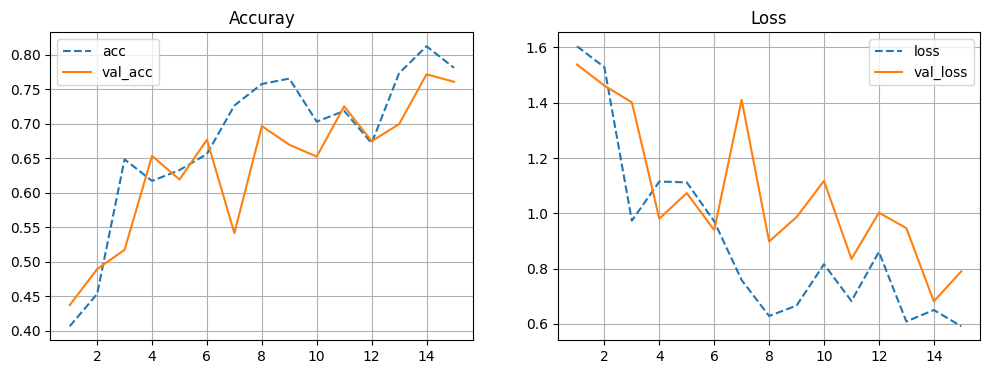

In [ ]:
print('Max Val_acc:',np.max(history1_plot['val_acc']))

xaxis = range(1, _epochs+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Accuray')
plt.plot(xaxis, history1_plot['acc'], '--', label='acc')
plt.plot(xaxis, history1_plot['val_acc'], '-', label='val_acc')
plt.grid(True)
#plt.ylim([0.95, 1.01])
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(xaxis, history1_plot['loss'], '--', label='loss')
plt.plot(xaxis, history1_plot['val_loss'], '-', label='val_loss')
plt.grid(True)
#plt.ylim([0.0, 0.6])
plt.legend()
plt.show()

# 과제3: learning rate schedule 적용 (목표: > 83%)


**성능이 가장 좋은 모델을 대상으로 적용해 보자**  
* epochs를 50까지 늘리고  
* 모델의 학습이 안정적으로 종료 됨을 확인하자


- **Learning Rate Scheduling 관련 참고용 코드**

In [ ]:
epochs=50
lr_start = 0.001 ##

In [ ]:
decay_steps = epochs//3
decay_rate=0.5
def exponential_decay_lambda(epoch):
    return decay_rate ** (epoch // decay_steps)

In [ ]:
exp_lr_s=[]

for step in range(epochs):
    exp_lr_s.append(exponential_decay_lambda(step)*lr_start)

plt.plot(exp_lr_s, linestyle='--', label="ExponentialDecay_step")
plt.legend()
plt.grid()


- configure_optimizers override

In [ ]:
class CNN_lr(CNN1): ##
    def __init__(self):
        super(CNN_lr, self).__init__()

    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.parameters(), lr=lr_start)
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                   lr_lambda = exponential_decay_lambda, verbose=True)
        return [optimizer], [lr_scheduler]

In [ ]:
%%time
cnn_lr = CNN_lr()

_epochs = 50
name = "cnn1_lr" ####
logger = CSVLogger("logs", name=name)
trainer = Trainer(max_epochs=_epochs, logger=logger, accelerator='auto',
                                    limit_train_batches=0.5, limit_val_batches=0.5 )
trainer.fit(cnn_lr, trainloader, testloader)

In [ ]:
v_num = logger.version
history1 = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')

history1_plot = history1.drop('step', axis=1).groupby('epoch').last()
history1_plot

## 과제 3-1

### LR tuning

In [ ]:
epochs=50
lr_start = 0.002 ##

In [ ]:
decay_steps = epochs//3
decay_rate=0.5
def exponential_decay_lambda(epoch):
    return decay_rate ** (epoch // decay_steps)

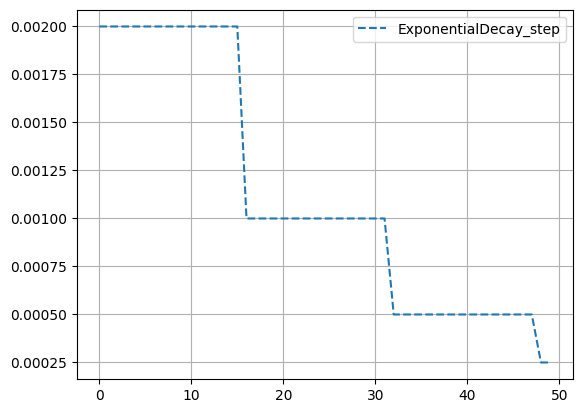

In [ ]:
exp_lr_s=[]

for step in range(epochs):
    exp_lr_s.append(exponential_decay_lambda(step)*lr_start)

plt.plot(exp_lr_s, linestyle='--', label="ExponentialDecay_step")
plt.legend()
plt.grid()


- configure_optimizers override

In [ ]:
class CNN_lr(CNN1): ##
    def __init__(self):
        super(CNN_lr, self).__init__()

    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.parameters(), lr=lr_start)
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                   lr_lambda = exponential_decay_lambda, verbose=True)
        return [optimizer], [lr_scheduler]

In [ ]:
%%time
cnn_lr = CNN_lr()

_epochs = 50
name = "cnn1_lr" ####
logger = CSVLogger("logs", name=name)
trainer = Trainer(max_epochs=_epochs, logger=logger, accelerator='auto',
                                    limit_train_batches=0.5, limit_val_batches=0.5 )
trainer.fit(cnn_lr, trainloader, testloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.1 M 
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.599     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 2.0000e-03.


Sanity Checking: 0it [00:00, ?it/s]

Epoch0 Val_loss:2.30, Val_acc:0.07


Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch0 Val_loss:1.66, Val_acc:0.42
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch1 Val_loss:1.36, Val_acc:0.62
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch2 Val_loss:0.88, Val_acc:0.73
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch3 Val_loss:1.28, Val_acc:0.60
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch4 Val_loss:1.43, Val_acc:0.59
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch5 Val_loss:0.61, Val_acc:0.79
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch6 Val_loss:0.82, Val_acc:0.73
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch7 Val_loss:0.89, Val_acc:0.70
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch8 Val_loss:0.88, Val_acc:0.74
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch9 Val_loss:0.57, Val_acc:0.82
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch10 Val_loss:0.77, Val_acc:0.73
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch11 Val_loss:1.04, Val_acc:0.71
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch12 Val_loss:1.10, Val_acc:0.73
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch13 Val_loss:0.59, Val_acc:0.83
Adjusting learning rate of group 0 to 2.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch14 Val_loss:0.99, Val_acc:0.70
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch15 Val_loss:1.10, Val_acc:0.71
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch16 Val_loss:0.37, Val_acc:0.89
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch17 Val_loss:0.36, Val_acc:0.91
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch18 Val_loss:0.47, Val_acc:0.87
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch19 Val_loss:0.42, Val_acc:0.86
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch20 Val_loss:0.43, Val_acc:0.90
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch21 Val_loss:0.54, Val_acc:0.88
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch22 Val_loss:0.68, Val_acc:0.85
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch23 Val_loss:0.35, Val_acc:0.91
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch24 Val_loss:0.45, Val_acc:0.86
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch25 Val_loss:0.52, Val_acc:0.87
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch26 Val_loss:0.49, Val_acc:0.91
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch27 Val_loss:0.78, Val_acc:0.82
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch28 Val_loss:0.74, Val_acc:0.83
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch29 Val_loss:0.35, Val_acc:0.90
Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch30 Val_loss:0.61, Val_acc:0.86
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch31 Val_loss:0.66, Val_acc:0.88
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch32 Val_loss:0.40, Val_acc:0.91
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch33 Val_loss:0.47, Val_acc:0.89
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch34 Val_loss:0.44, Val_acc:0.92
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch35 Val_loss:0.45, Val_acc:0.91
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch36 Val_loss:0.45, Val_acc:0.91
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch37 Val_loss:0.48, Val_acc:0.91
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch38 Val_loss:0.40, Val_acc:0.92
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch39 Val_loss:0.44, Val_acc:0.90
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch40 Val_loss:0.63, Val_acc:0.87
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch41 Val_loss:0.39, Val_acc:0.90
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch42 Val_loss:0.55, Val_acc:0.91
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch43 Val_loss:0.61, Val_acc:0.90
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch44 Val_loss:0.58, Val_acc:0.88
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch45 Val_loss:0.65, Val_acc:0.90
Adjusting learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch46 Val_loss:0.59, Val_acc:0.91
Adjusting learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Epoch47 Val_loss:0.53, Val_acc:0.91
Adjusting learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Epoch48 Val_loss:0.52, Val_acc:0.91
Adjusting learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Epoch49 Val_loss:0.54, Val_acc:0.91


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 7min 11s, sys: 2.99 s, total: 7min 14s
Wall time: 7min 29s


In [ ]:
v_num = logger.version
history1 = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')

history1_plot = history1.drop('step', axis=1).groupby('epoch').last()
history1_plot

,loss,acc,val_loss,val_acc
epoch,,,,
0,1.452194,0.468750,1.649957,0.416466
1,1.313419,0.453125,1.386097,0.492989
2,1.102031,0.640625,0.917436,0.686098
3,1.056823,0.625000,1.528026,0.526843
4,0.872826,0.695312,1.796773,0.474359
5,0.741752,0.718750,0.733548,0.754407
6,0.739854,0.734375,0.928184,0.704527
7,0.609967,0.757812,1.026231,0.667268
8,0.662200,0.742188,0.902305,0.705128


### ***Analysis***

Max Val_acc: 0.8752003312110901


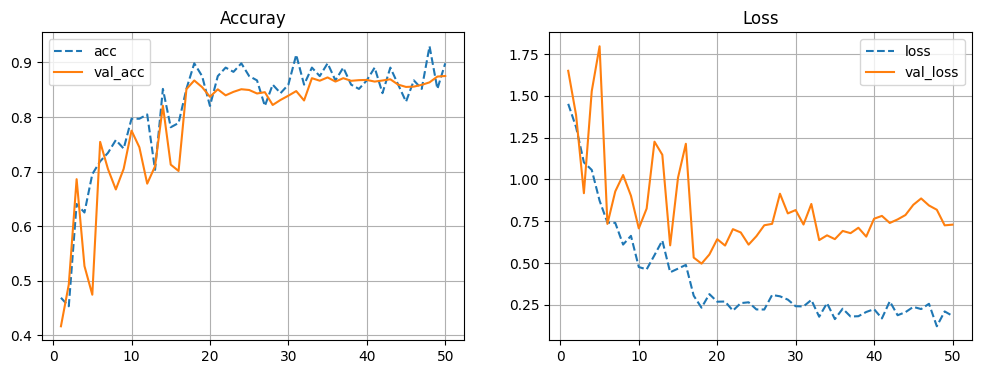

In [ ]:
print('Max Val_acc:',np.max(history1_plot['val_acc']))

xaxis = range(1, _epochs+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Accuray')
plt.plot(xaxis, history1_plot['acc'], '--', label='acc')
plt.plot(xaxis, history1_plot['val_acc'], '-', label='val_acc')
plt.grid(True)
#plt.ylim([0.95, 1.01])
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(xaxis, history1_plot['loss'], '--', label='loss')
plt.plot(xaxis, history1_plot['val_loss'], '-', label='val_loss')
plt.grid(True)
#plt.ylim([0.0, 0.6])
plt.legend()
plt.show()

## 과제 3-2

### LR tuning

In [ ]:
epochs=50
lr_start = 0.002 ##

In [ ]:
decay_rate=0.95
def exponential_decay_lambda(epoch):
    return decay_rate ** epoch

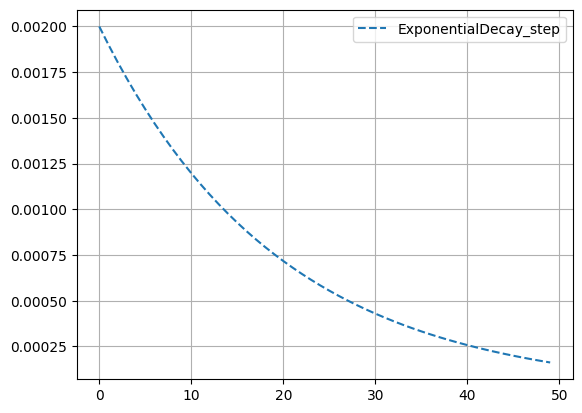

In [ ]:
exp_lr_s=[]

for step in range(epochs):
    exp_lr_s.append(exponential_decay_lambda(step)*lr_start)

plt.plot(exp_lr_s, linestyle='--', label="ExponentialDecay_step")
plt.legend()
plt.grid()


- configure_optimizers override

In [ ]:
class CNN_lr(CNN1): ##
    def __init__(self):
        super(CNN_lr, self).__init__()

    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.parameters(), lr=lr_start)
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                   lr_lambda = exponential_decay_lambda, verbose=True)
        return [optimizer], [lr_scheduler]

In [ ]:
%%time
cnn_lr = CNN_lr()

_epochs = 50
name = "cnn1_lr" ####
logger = CSVLogger("logs", name=name)
trainer = Trainer(max_epochs=_epochs, logger=logger, accelerator='auto',
                                    limit_train_batches=0.5, limit_val_batches=0.5 )
trainer.fit(cnn_lr, trainloader, testloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.1 M 
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.599     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 2.0000e-03.


Sanity Checking: 0it [00:00, ?it/s]

Epoch0 Val_loss:2.30, Val_acc:0.15


Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.9000e-03.


Validation: 0it [00:00, ?it/s]

Epoch0 Val_loss:1.91, Val_acc:0.37
Adjusting learning rate of group 0 to 1.8050e-03.


Validation: 0it [00:00, ?it/s]

Epoch1 Val_loss:1.33, Val_acc:0.54
Adjusting learning rate of group 0 to 1.7147e-03.


Validation: 0it [00:00, ?it/s]

Epoch2 Val_loss:1.05, Val_acc:0.61
Adjusting learning rate of group 0 to 1.6290e-03.


Validation: 0it [00:00, ?it/s]

Epoch3 Val_loss:0.94, Val_acc:0.66
Adjusting learning rate of group 0 to 1.5476e-03.


Validation: 0it [00:00, ?it/s]

Epoch4 Val_loss:0.74, Val_acc:0.76
Adjusting learning rate of group 0 to 1.4702e-03.


Validation: 0it [00:00, ?it/s]

Epoch5 Val_loss:0.62, Val_acc:0.78
Adjusting learning rate of group 0 to 1.3967e-03.


Validation: 0it [00:00, ?it/s]

Epoch6 Val_loss:0.57, Val_acc:0.80
Adjusting learning rate of group 0 to 1.3268e-03.


Validation: 0it [00:00, ?it/s]

Epoch7 Val_loss:0.95, Val_acc:0.73
Adjusting learning rate of group 0 to 1.2605e-03.


Validation: 0it [00:00, ?it/s]

Epoch8 Val_loss:0.64, Val_acc:0.77
Adjusting learning rate of group 0 to 1.1975e-03.


Validation: 0it [00:00, ?it/s]

Epoch9 Val_loss:0.49, Val_acc:0.87
Adjusting learning rate of group 0 to 1.1376e-03.


Validation: 0it [00:00, ?it/s]

Epoch10 Val_loss:0.43, Val_acc:0.82
Adjusting learning rate of group 0 to 1.0807e-03.


Validation: 0it [00:00, ?it/s]

Epoch11 Val_loss:0.51, Val_acc:0.81
Adjusting learning rate of group 0 to 1.0267e-03.


Validation: 0it [00:00, ?it/s]

Epoch12 Val_loss:0.51, Val_acc:0.86
Adjusting learning rate of group 0 to 9.7535e-04.


Validation: 0it [00:00, ?it/s]

Epoch13 Val_loss:0.70, Val_acc:0.75
Adjusting learning rate of group 0 to 9.2658e-04.


Validation: 0it [00:00, ?it/s]

Epoch14 Val_loss:0.53, Val_acc:0.82
Adjusting learning rate of group 0 to 8.8025e-04.


Validation: 0it [00:00, ?it/s]

Epoch15 Val_loss:0.41, Val_acc:0.88
Adjusting learning rate of group 0 to 8.3624e-04.


Validation: 0it [00:00, ?it/s]

Epoch16 Val_loss:0.34, Val_acc:0.88
Adjusting learning rate of group 0 to 7.9443e-04.


Validation: 0it [00:00, ?it/s]

Epoch17 Val_loss:0.47, Val_acc:0.88
Adjusting learning rate of group 0 to 7.5471e-04.


Validation: 0it [00:00, ?it/s]

Epoch18 Val_loss:0.49, Val_acc:0.85
Adjusting learning rate of group 0 to 7.1697e-04.


Validation: 0it [00:00, ?it/s]

Epoch19 Val_loss:0.36, Val_acc:0.89
Adjusting learning rate of group 0 to 6.8112e-04.


Validation: 0it [00:00, ?it/s]

Epoch20 Val_loss:0.47, Val_acc:0.88
Adjusting learning rate of group 0 to 6.4707e-04.


Validation: 0it [00:00, ?it/s]

Epoch21 Val_loss:0.49, Val_acc:0.88
Adjusting learning rate of group 0 to 6.1471e-04.


Validation: 0it [00:00, ?it/s]

Epoch22 Val_loss:0.39, Val_acc:0.91
Adjusting learning rate of group 0 to 5.8398e-04.


Validation: 0it [00:00, ?it/s]

Epoch23 Val_loss:0.51, Val_acc:0.90
Adjusting learning rate of group 0 to 5.5478e-04.


Validation: 0it [00:00, ?it/s]

Epoch24 Val_loss:0.51, Val_acc:0.88
Adjusting learning rate of group 0 to 5.2704e-04.


Validation: 0it [00:00, ?it/s]

Epoch25 Val_loss:0.40, Val_acc:0.91
Adjusting learning rate of group 0 to 5.0069e-04.


Validation: 0it [00:00, ?it/s]

Epoch26 Val_loss:0.56, Val_acc:0.90
Adjusting learning rate of group 0 to 4.7565e-04.


Validation: 0it [00:00, ?it/s]

Epoch27 Val_loss:0.41, Val_acc:0.91
Adjusting learning rate of group 0 to 4.5187e-04.


Validation: 0it [00:00, ?it/s]

Epoch28 Val_loss:0.46, Val_acc:0.91
Adjusting learning rate of group 0 to 4.2928e-04.


Validation: 0it [00:00, ?it/s]

Epoch29 Val_loss:0.28, Val_acc:0.92
Adjusting learning rate of group 0 to 4.0781e-04.


Validation: 0it [00:00, ?it/s]

Epoch30 Val_loss:0.48, Val_acc:0.90
Adjusting learning rate of group 0 to 3.8742e-04.


Validation: 0it [00:00, ?it/s]

Epoch31 Val_loss:0.41, Val_acc:0.91
Adjusting learning rate of group 0 to 3.6805e-04.


Validation: 0it [00:00, ?it/s]

Epoch32 Val_loss:0.42, Val_acc:0.90
Adjusting learning rate of group 0 to 3.4965e-04.


Validation: 0it [00:00, ?it/s]

Epoch33 Val_loss:0.43, Val_acc:0.92
Adjusting learning rate of group 0 to 3.3217e-04.


Validation: 0it [00:00, ?it/s]

Epoch34 Val_loss:0.37, Val_acc:0.91
Adjusting learning rate of group 0 to 3.1556e-04.


Validation: 0it [00:00, ?it/s]

Epoch35 Val_loss:0.38, Val_acc:0.89
Adjusting learning rate of group 0 to 2.9978e-04.


Validation: 0it [00:00, ?it/s]

Epoch36 Val_loss:0.42, Val_acc:0.92
Adjusting learning rate of group 0 to 2.8479e-04.


Validation: 0it [00:00, ?it/s]

Epoch37 Val_loss:0.40, Val_acc:0.92
Adjusting learning rate of group 0 to 2.7055e-04.


Validation: 0it [00:00, ?it/s]

Epoch38 Val_loss:0.43, Val_acc:0.91
Adjusting learning rate of group 0 to 2.5702e-04.


Validation: 0it [00:00, ?it/s]

Epoch39 Val_loss:0.44, Val_acc:0.92
Adjusting learning rate of group 0 to 2.4417e-04.


Validation: 0it [00:00, ?it/s]

Epoch40 Val_loss:0.61, Val_acc:0.89
Adjusting learning rate of group 0 to 2.3196e-04.


Validation: 0it [00:00, ?it/s]

Epoch41 Val_loss:0.60, Val_acc:0.89
Adjusting learning rate of group 0 to 2.2037e-04.


Validation: 0it [00:00, ?it/s]

Epoch42 Val_loss:0.49, Val_acc:0.91
Adjusting learning rate of group 0 to 2.0935e-04.


Validation: 0it [00:00, ?it/s]

Epoch43 Val_loss:0.51, Val_acc:0.90
Adjusting learning rate of group 0 to 1.9888e-04.


Validation: 0it [00:00, ?it/s]

Epoch44 Val_loss:0.49, Val_acc:0.92
Adjusting learning rate of group 0 to 1.8894e-04.


Validation: 0it [00:00, ?it/s]

Epoch45 Val_loss:0.49, Val_acc:0.91
Adjusting learning rate of group 0 to 1.7949e-04.


Validation: 0it [00:00, ?it/s]

Epoch46 Val_loss:0.50, Val_acc:0.91
Adjusting learning rate of group 0 to 1.7052e-04.


Validation: 0it [00:00, ?it/s]

Epoch47 Val_loss:0.52, Val_acc:0.91
Adjusting learning rate of group 0 to 1.6199e-04.


Validation: 0it [00:00, ?it/s]

Epoch48 Val_loss:0.52, Val_acc:0.91
Adjusting learning rate of group 0 to 1.5389e-04.


Validation: 0it [00:00, ?it/s]

Epoch49 Val_loss:0.48, Val_acc:0.91


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 7min 11s, sys: 3.01 s, total: 7min 14s
Wall time: 7min 21s


In [ ]:
v_num = logger.version
history1 = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')

history1_plot = history1.drop('step', axis=1).groupby('epoch').last()
history1_plot

,loss,acc,val_loss,val_acc
epoch,,,,
0,1.476984,0.445312,1.681377,0.417869
1,1.174867,0.593750,1.490992,0.477965
2,1.074967,0.640625,1.084621,0.590144
3,1.108794,0.601562,1.051148,0.639223
4,0.789493,0.710938,0.880857,0.689503
5,0.700186,0.765625,0.703423,0.757812
6,0.587550,0.765625,0.768892,0.741587
7,0.654554,0.703125,0.948734,0.708934
8,0.641438,0.765625,0.725235,0.762620


### ***Analysis***

Max Val_acc: 0.8756009340286255


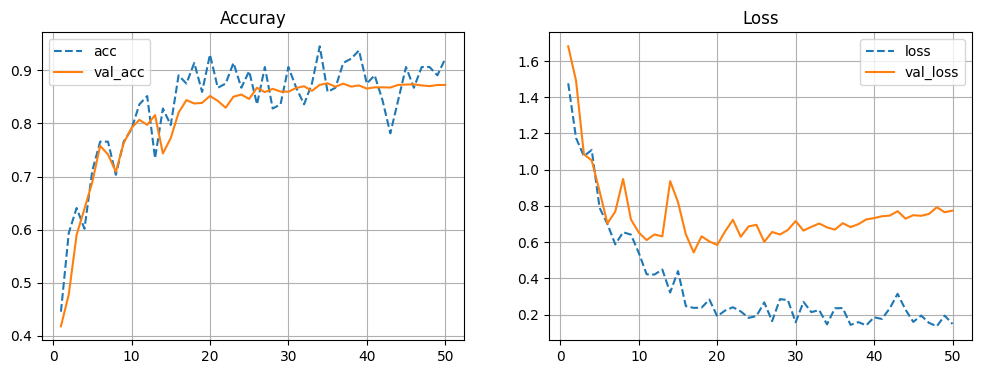

In [ ]:
print('Max Val_acc:',np.max(history1_plot['val_acc']))

xaxis = range(1, _epochs+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Accuray')
plt.plot(xaxis, history1_plot['acc'], '--', label='acc')
plt.plot(xaxis, history1_plot['val_acc'], '-', label='val_acc')
plt.grid(True)
#plt.ylim([0.95, 1.01])
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(xaxis, history1_plot['loss'], '--', label='loss')
plt.plot(xaxis, history1_plot['val_loss'], '-', label='val_loss')
plt.grid(True)
#plt.ylim([0.0, 0.6])
plt.legend()
plt.show()

# 과제4 : Conv Filter 및 Feature Map 시각화

* 과제2에서 학습된 모델에서  
* 모든 Conv Layer의 Feature Map을 시각화 해보자   

In [ ]:
### model name 수정 필요 ###

# summarize filter shapes
filter_list = []
for i, layer in enumerate(cnn1.layers):
    # check for convolutional layer
    if 'Conv' not in str(layer.__class__):
        continue #'conv'가 포함되지 않으면 skip
    # get filter weights
    filters = layer.weight
    filter_list.append(filters) #use_bias=False
    print(f'[{i}]th layer:{layer.__class__}  {filters.shape}')

[0]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 3, 3, 3])
[3]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 64, 3, 3])
[7]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([128, 64, 3, 3])
[10]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([128, 128, 3, 3])
[14]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([256, 128, 3, 3])
[17]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([256, 256, 3, 3])


In [ ]:
# plot n x n images
def square(imgs, n):
    img_num = n
    plt.figure(figsize=(10,10))
    print(f'min[{np.min(imgs):2.2f}],max[{np.max(imgs):2.2f}]')
    f_min, f_max = imgs.min(), imgs.max() #(3,3,64,64)
    imgs = (imgs - f_min) / (f_max - f_min)
    for i in range(n):
        for j in range(n):
            p_num = i*n + j
            ax = plt.subplot(n, n, p_num+1)#(row,col,index)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(imgs[p_num, :, :], cmap='gray')
    plt.show()

* 첫번째 conv layer filter

In [ ]:
filters[:,0,:,:].shape # 입력채널을 향한 64 node의 weight

torch.Size([256, 3, 3])

torch.Size([64, 3, 3])
min[-0.28],max[0.24]


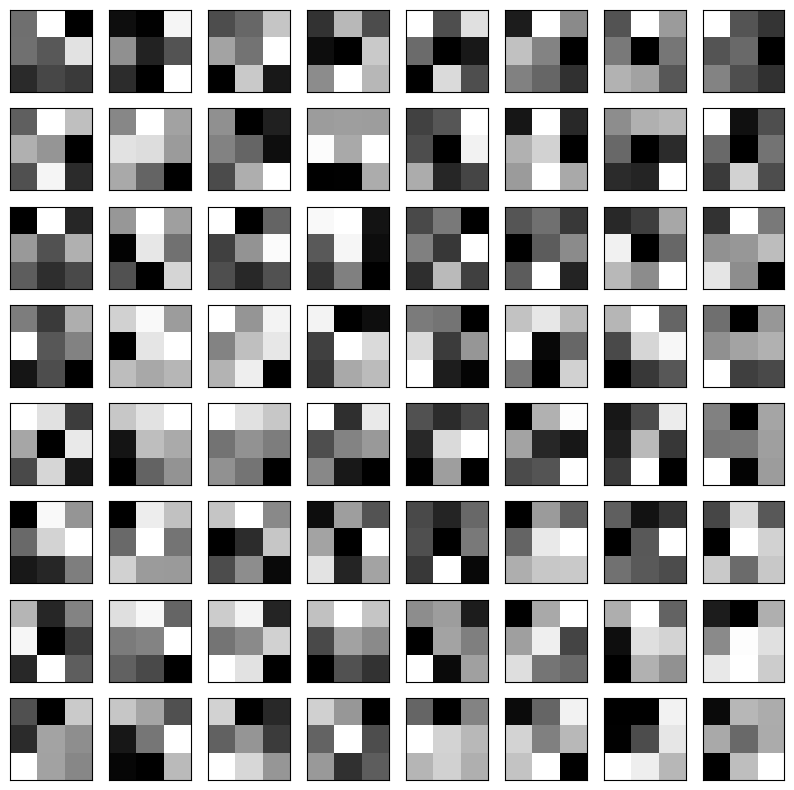

In [ ]:
filters = filter_list[0]
# in_0, out_all
print(filters[:,0,:,:].shape)
square(filters[:,0,:,:].cpu().detach().numpy(), 8)

### Feature map extract model define

In [ ]:
### model name 수정 필요 ###

class CNN_FM(CNN1):
    def __init__(self):
        super(CNN_FM, self).__init__()

    def forward(self, x):
        # out1 = self.layers[0](x)
        # out2 = self.layers[:4](x) ##
        # out3 = self.layers[:7](x) ##

        out0 = self.layers[0](x)
        out1 = self.layers[:4](x)
        out2 = self.layers[:12](x)
        out3 = self.layers[:19](x)
        return out0, out1, out2, out3

model_FM = CNN_FM()
summary(model_FM, input_size=(8, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_FM                                   [8, 64, 32, 32]           --
├─Sequential: 1-1                        --                        2,571
│    └─Conv2d: 2-1                       [8, 64, 32, 32]           1,792
│    └─Conv2d: 2-2                       [8, 64, 32, 32]           (recursive)
│    └─BatchNorm2d: 2-3                  [8, 64, 32, 32]           128
│    └─PReLU: 2-4                        [8, 64, 32, 32]           1
│    └─Conv2d: 2-5                       [8, 64, 32, 32]           36,928
│    └─Conv2d: 2-6                       [8, 64, 32, 32]           (recursive)
│    └─BatchNorm2d: 2-7                  [8, 64, 32, 32]           (recursive)
│    └─PReLU: 2-8                        [8, 64, 32, 32]           (recursive)
│    └─Conv2d: 2-9                       [8, 64, 32, 32]           (recursive)
│    └─BatchNorm2d: 2-10                 [8, 64, 32, 32]           128
│    └─PReLU: 2-11           

In [ ]:
model_FM

CNN_FM(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): PReLU(num_parameters=1)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [ ]:
# conv layer 위치 확인
for i, layer in enumerate(model_FM.layers):
    # check for convolutional layer
    if 'Conv' not in str(layer.__class__):
        continue #'conv'가 포함되지 않으면 skip
    # get filter weights
    filters = layer.weight
    print(f'[{i}]th layer:{layer.__class__}  {filters.shape}')

[0]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 3, 3, 3])
[3]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([64, 64, 3, 3])
[7]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([128, 64, 3, 3])
[10]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([128, 128, 3, 3])
[14]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([256, 128, 3, 3])
[17]th layer:<class 'torch.nn.modules.conv.Conv2d'>  torch.Size([256, 256, 3, 3])


- Get feature maps : fm_model.predict( )

In [ ]:
testset[0][0].shape # (index,image/label)

torch.Size([3, 32, 32])

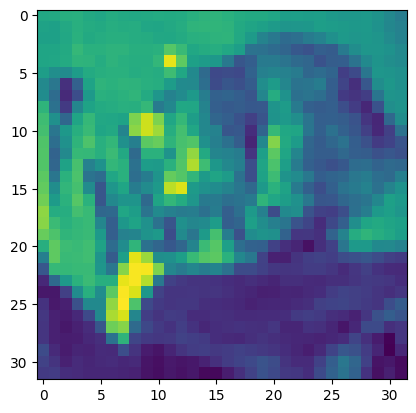

In [ ]:
plt.imshow(testset[0][0][0])

In [ ]:
# Returns 3 items tuple(tensor, grad_fn)
n=0 # 첫번째 이미지를 넣고 추론하면서, feature를 반환 받음
#[(1,28,28,64),(1,14,14,64),(1,7,7,64)]
feature_maps = model_FM(
    testset[0][0].unsqueeze(dim=0).to(device))

In [ ]:
pst(feature_maps[0]) # torch.Tensor:(tensor,grad_fn)
pst(feature_maps[1])
pst(feature_maps[2])

[] Shapetorch.Size([1, 64, 32, 32]), <class 'torch.Tensor'>
[] Shapetorch.Size([1, 64, 32, 32]), <class 'torch.Tensor'>
[] Shapetorch.Size([1, 128, 16, 16]), <class 'torch.Tensor'>


#### Plot the feature maps

min[-1.43],max[1.26]


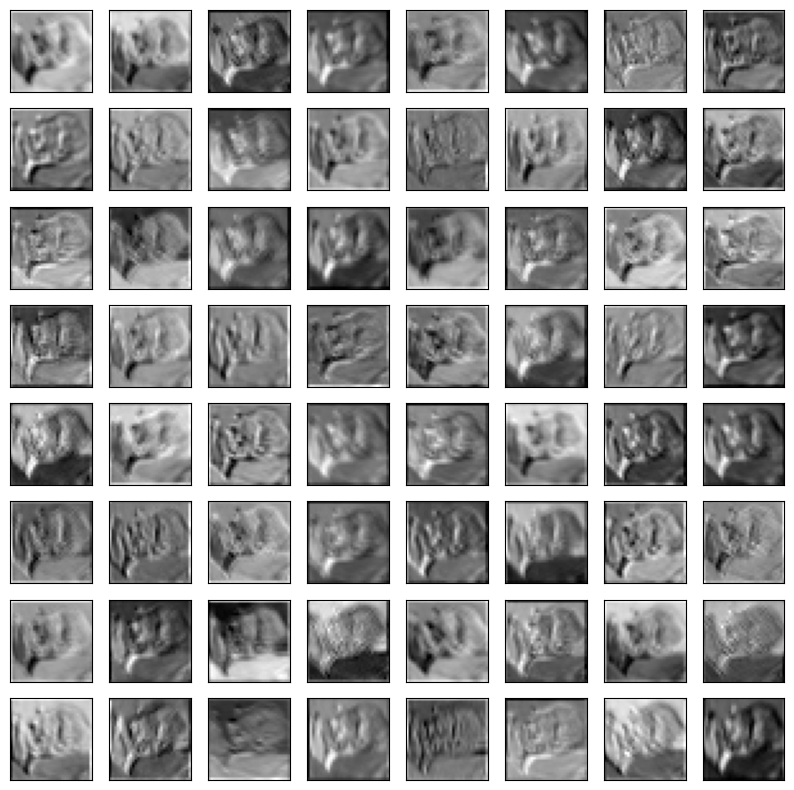

min[-3.14],max[2.25]


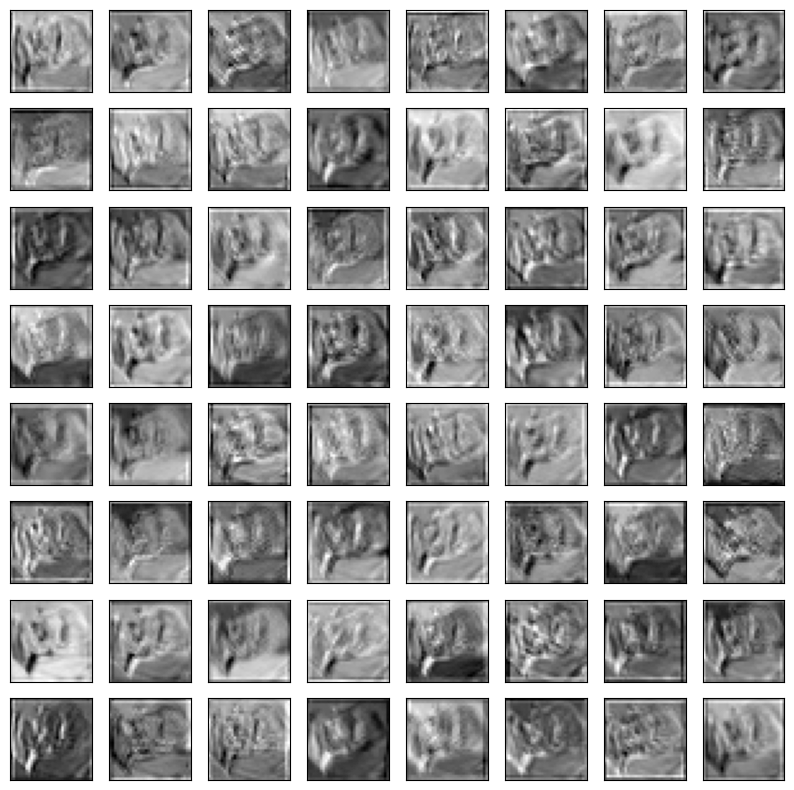

min[-4.70],max[4.57]


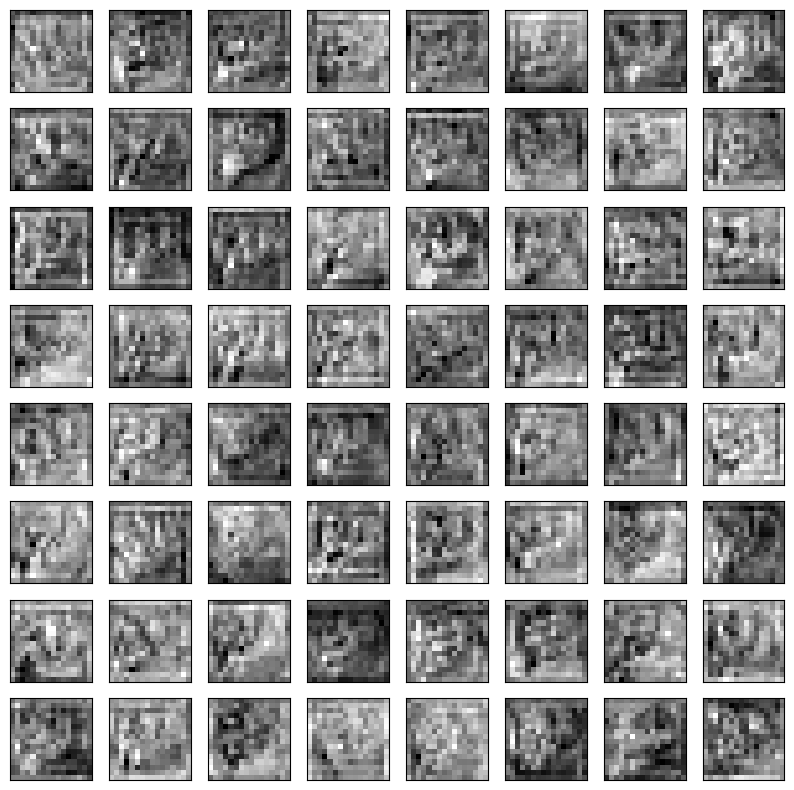

min[-3.90],max[3.81]


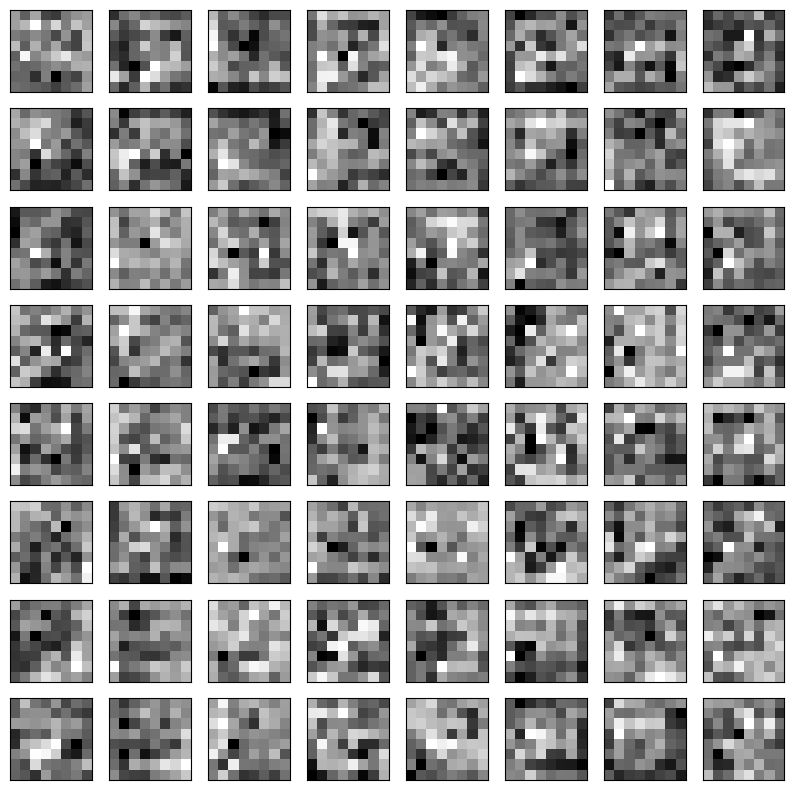

In [ ]:
# 3개의 레이어가 출력한 각64개의 feature map
for i, fmap in enumerate(feature_maps):
    square(fmap.cpu().detach().numpy()[0], 8)